In [2]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
import re
import math
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler

spark = SparkSession.builder.appName('example code').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext
spark.conf.set('spark.sql.session.timeZone', 'UTC')
bitcoin_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('Symbol', types.StringType()),
    types.StructField('Open', types.FloatType()),
    types.StructField('High', types.FloatType()),
    types.StructField('Low', types.FloatType()),
    types.StructField('Close', types.FloatType()),
    types.StructField('Volume BTC', types.FloatType()),
    types.StructField('Volume USD', types.FloatType()),
])

In [3]:
col_order = ["timestamp", "Symbol", "Open", "High", "Low", "Close", "Volume BTC", "Volume USD"]
w =Window.partitionBy('Symbol').orderBy(functions.col("timestamp").cast('long'))
lag =5
diff_lst = [i for i in range(1, lag+1)]

In [4]:
data = spark.read.csv("bitcoin-usd-hour.csv", schema=bitcoin_schema).cache()
data = data.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd hh-aa').cast("timestamp")).drop('Date')
data = data.select(col_order).cache()
data.show()

+-------------------+------+-------+-------+-------+-------+----------+----------+
|          timestamp|Symbol|   Open|   High|    Low|  Close|Volume BTC|Volume USD|
+-------------------+------+-------+-------+-------+-------+----------+----------+
|2019-11-11 18:00:00|BTCUSD| 8933.0|8992.89| 8933.0|8986.58|      8.38|  75044.04|
|2019-11-11 17:00:00|BTCUSD|8956.29| 8988.0|8891.14| 8933.0|      15.8| 141111.16|
|2019-11-11 16:00:00|BTCUSD|8931.63|8995.76|8922.65|8956.29|     10.68|  95636.33|
|2019-11-11 15:00:00|BTCUSD|8986.69|8986.69| 8917.0|8931.63|     11.56| 103440.38|
|2019-11-11 14:00:00|BTCUSD|8934.75|8988.07| 8922.0|8986.69|     9.884|  88498.69|
|2019-11-11 13:00:00|BTCUSD| 8950.0|8969.78|8927.87|8934.75|     9.437|  84459.86|
|2019-11-11 12:00:00|BTCUSD|8957.96| 8975.9|8907.03| 8950.0|     10.66|  95375.83|
|2019-11-11 11:00:00|BTCUSD| 8949.4| 8987.5| 8900.0|8957.96|     12.41| 110842.47|
|2019-11-11 10:00:00|BTCUSD|8871.97|8966.51|8861.32| 8949.4|     13.61| 121248.03|
|201

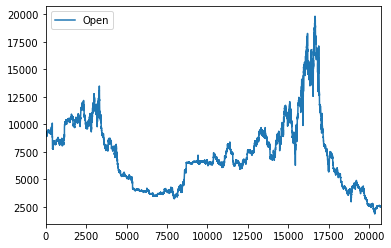

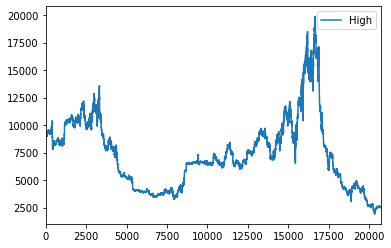

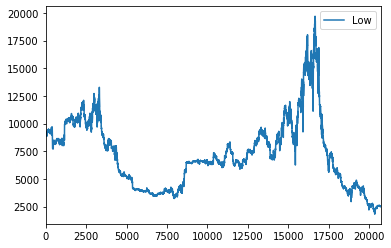

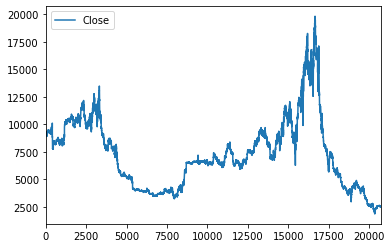

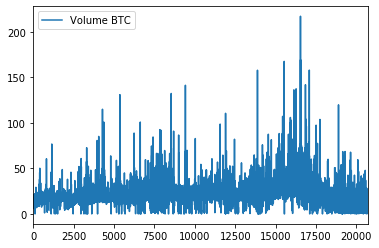

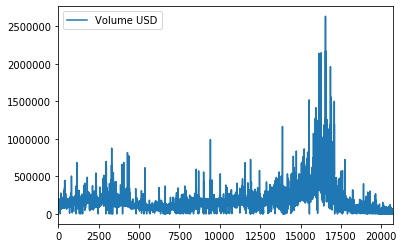

In [6]:
pdf1=data.select(col_order[2:]).toPandas()

for feature in col_order[2:]:
    pdf1.plot(y=feature)

In [5]:
# marksColumns = []
for feature in col_order[2:]:
    for diff in diff_lst:
        name = feature + "_lag_{}".format(diff)
        data = data.withColumn(name, functions.lag(data[feature], count=diff).over(w))
        data = data.fillna({name:0})
        
# drop working cols
data.sort("timestamp").show(1)

+-------------------+------+------+-------+------+------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|          timestamp|Symbol|  Open|   High|   Low| Close|Volume BTC|Volume USD|Open_lag_1|Open_lag_2|Open_lag_3|Open_lag_4|Open_lag_5|High_lag_1|High_lag_2|High_lag_3|High_lag_4|High_lag_5|Low_lag_1|Low_lag_2|Low_lag_3|Low_lag_4|Low_lag_5|Close_lag_1|Close_lag_2|Close_lag_3|Close_lag_4|Close_lag_5|Volume BTC_lag_1|Volume BTC_lag_2|Volume BTC_lag_3|Volume BTC_lag_4|Volume BTC_lag_5|Volume USD_lag_1|Volume USD_lag_2|Volume USD_lag_3|Volume USD_lag_4|Volume USD_lag_5|
+-------------------+------+------+-------+------+------+---

In [6]:
featureCols = []
for feature in col_order[2:]:
    if feature != "Close":
        featureCols.append(feature)
    for diff in diff_lst:
        featureCols.append(feature + "_lag_{}".format(diff))
featureCols

['Open',
 'Open_lag_1',
 'Open_lag_2',
 'Open_lag_3',
 'Open_lag_4',
 'Open_lag_5',
 'High',
 'High_lag_1',
 'High_lag_2',
 'High_lag_3',
 'High_lag_4',
 'High_lag_5',
 'Low',
 'Low_lag_1',
 'Low_lag_2',
 'Low_lag_3',
 'Low_lag_4',
 'Low_lag_5',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'Close_lag_4',
 'Close_lag_5',
 'Volume BTC',
 'Volume BTC_lag_1',
 'Volume BTC_lag_2',
 'Volume BTC_lag_3',
 'Volume BTC_lag_4',
 'Volume BTC_lag_5',
 'Volume USD',
 'Volume USD_lag_1',
 'Volume USD_lag_2',
 'Volume USD_lag_3',
 'Volume USD_lag_4',
 'Volume USD_lag_5']

In [7]:
assembler = VectorAssembler(
        inputCols=featureCols,
        outputCol='features'

)

regressor2 = RandomForestRegressor(
    featuresCol='features',
    labelCol='Close',
    maxDepth=12,
    maxBins=32
    
)

# regressor4 = DecisionTreeRegressor(
#     featuresCol='features',
#     labelCol='Close'
# )


In [8]:
transformed =  assembler.transform(data)
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(transformed.select("features"))
scaledData = scalerModel.transform(transformed)

In [9]:
train, validation = scaledData.randomSplit([0.7, 0.3])
train = train.cache()
validation = validation.cache()

In [10]:
pipeline = Pipeline(stages=[regressor2])
model = pipeline.fit(train)
predictions = model.transform(validation)
pred_df = predictions.select("Close", "prediction")
pred_df.show(3)

Py4JJavaError: An error occurred while calling o291.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 71 in stage 53.0 failed 1 times, most recent failure: Lost task 71.0 in stage 53.0 (TID 5323, localhost, executor driver): ExecutorLostFailure (executor driver exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 61721784 ms
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:567)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:201)
	at org.apache.spark.ml.regression.RandomForestRegressor$$anonfun$train$1.apply(RandomForestRegressor.scala:133)
	at org.apache.spark.ml.regression.RandomForestRegressor$$anonfun$train$1.apply(RandomForestRegressor.scala:119)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:119)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


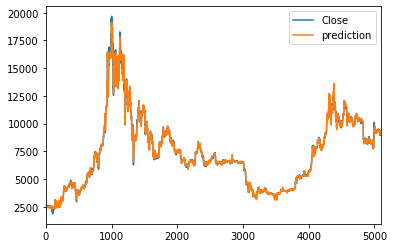

In [17]:
pred_pdf= pred_df.toPandas()
pred_pdf.plot(y=["Close", "prediction"])

In [18]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="rmse")
score = evaluator.evaluate(predictions)

print('R square error is: %g' % (score))

R square error is: 198.22


In [46]:
model.stages[-1].featureImportances

SparseVector(23, {0: 0.1932, 1: 0.0442, 2: 0.0005, 3: 0.0003, 4: 0.1313, 5: 0.0609, 6: 0.0012, 7: 0.0002, 8: 0.3633, 9: 0.0793, 10: 0.0004, 11: 0.0003, 12: 0.1028, 13: 0.02, 14: 0.0004, 15: 0.0001, 16: 0.0002, 17: 0.0001, 18: 0.0001, 19: 0.0005, 20: 0.0003, 21: 0.0003, 22: 0.0004})